# Modern Portfolio Theory

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import get_data

plt.style.use('seaborn')

In [43]:
PATH = 'data/modern_portfolio_theory.crypto.csv'
stocks = ['BTC-EUR', 'ETH-EUR', 'DOGE-EUR', 'ADA-EUR', 'SHIB-EUR']

# Get stock data

array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>]],
      dtype=object)

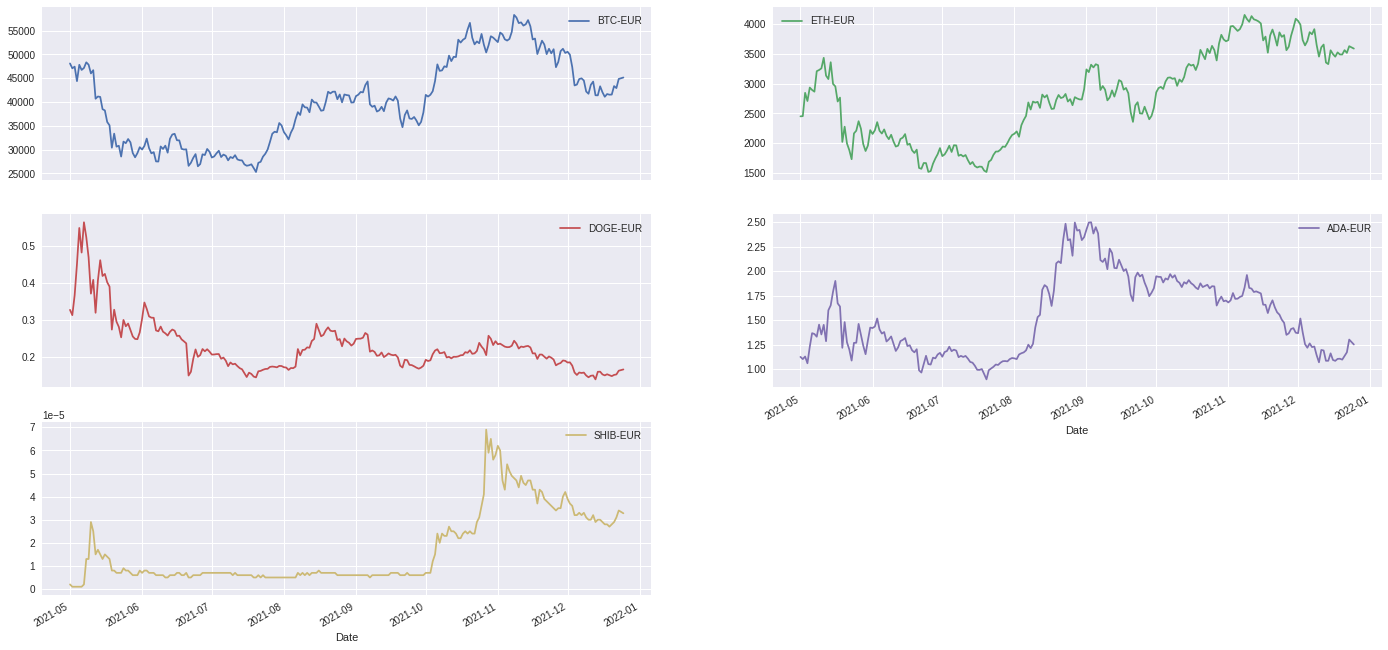

In [44]:
df = get_data(path=PATH, stocks=stocks, fetch=True).loc['2021-05-01':]

df.plot(figsize=(24, 12), subplots=True, layout=(3, 2))

array([[<AxesSubplot:title={'center':'BTC-EUR'}>,
        <AxesSubplot:title={'center':'ETH-EUR'}>],
       [<AxesSubplot:title={'center':'DOGE-EUR'}>,
        <AxesSubplot:title={'center':'ADA-EUR'}>],
       [<AxesSubplot:title={'center':'SHIB-EUR'}>, <AxesSubplot:>]],
      dtype=object)

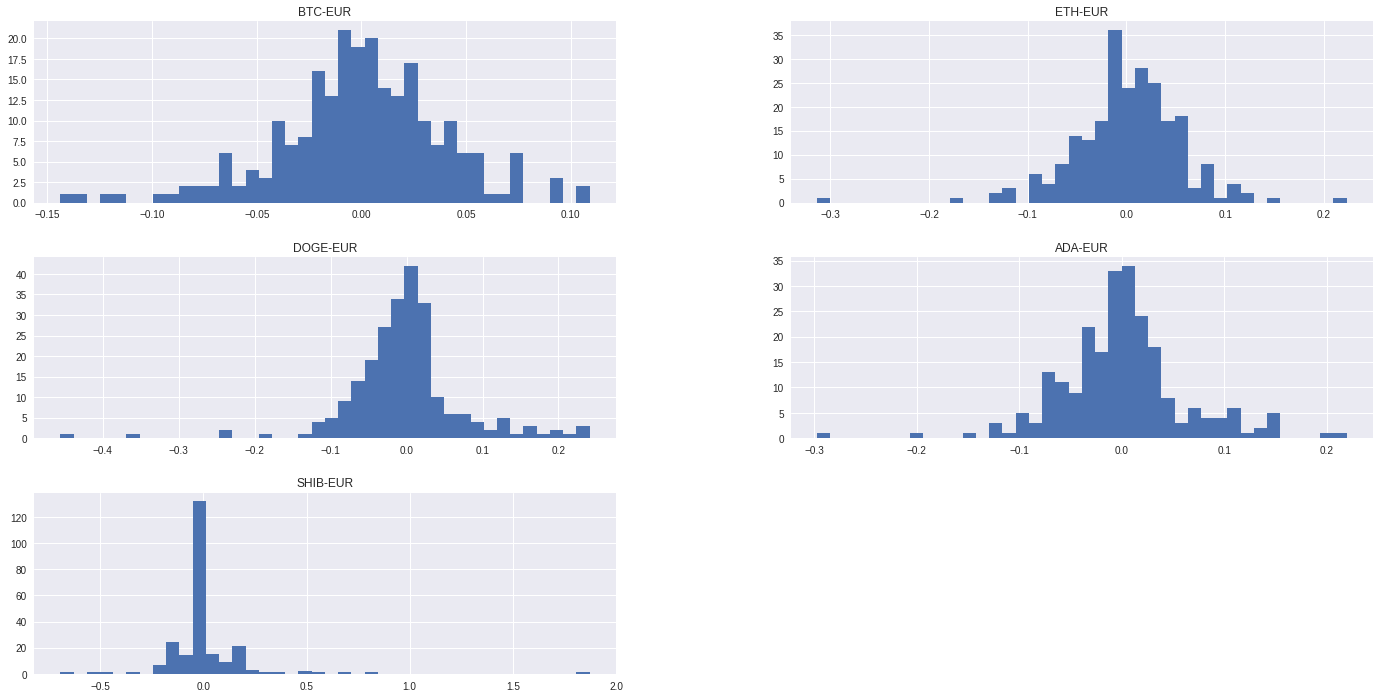

In [45]:
returns = np.log(df / df.shift(1)).dropna()

returns.hist(bins=40, figsize=(24, 12))

In [46]:
returns.mean() * 252

Symbols
BTC-EUR    -0.067485
ETH-EUR     0.405209
DOGE-EUR   -0.718317
ADA-EUR     0.113266
SHIB-EUR    2.973882
dtype: float64

In [47]:
returns.cov() * 252

Symbols,BTC-EUR,ETH-EUR,DOGE-EUR,ADA-EUR,SHIB-EUR
Symbols,,,,,
BTC-EUR,0.411671,0.460283,0.533606,0.439725,0.638024
ETH-EUR,0.460283,0.774333,0.732797,0.619591,0.966258
DOGE-EUR,0.533606,0.732797,1.538486,0.794323,0.887489
ADA-EUR,0.439725,0.619591,0.794323,0.957802,0.537551
SHIB-EUR,0.638024,0.966258,0.887489,0.537551,8.985127


In [48]:
# generate random weights
weights = np.random.random(len(stocks))
weights /= np.sum(weights)

# annualized portfolio return
np.sum(returns.mean() * weights) * 252

1.0424572106050007

In [49]:
# annualized portfolio volatility
np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

1.2585204082999404

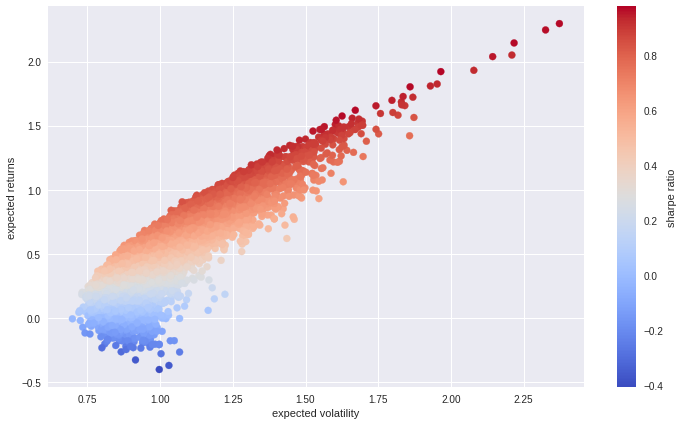

In [50]:
def portfolio_returns(weights):
    return np.sum(returns.mean() * weights) * 252
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

prets = []
pvols = []
for p in range(5000):
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)
    prets.append(portfolio_returns(weights))
    pvols.append(portfolio_volatility(weights))
    
prets = np.array(prets)
pvols = np.array(pvols)

plt.figure(figsize=(12, 7))
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected returns')
plt.colorbar(label='sharpe ratio')

## Find best weights

In [51]:
import scipy.optimize as sco

def min_sharpe(weights):
    return -portfolio_returns(weights) / portfolio_volatility(weights)

cons = ({
    'type': 'eq',
    'fun': lambda x: np.sum(x) - 1
})
bnds = tuple((0, 1) for _ in range(len(stocks)))
eweights = np.array(len(stocks) * [1. / len(weights)])
print(min_sharpe(eweights))

-0.531959178474738


### Weights with max Sharpe ratio

In [52]:
opts = sco.minimize(
    min_sharpe,
    eweights,
    method='SLSQP',
    bounds=bnds,
    constraints=cons
)
print(stocks)
print('weights', opts['x'].round(3))
print('returns', portfolio_returns(opts['x']).round(5) * 100, '%')
print('volatility', portfolio_volatility(opts['x']))
print('sharpe ratio', portfolio_returns(opts['x']) / portfolio_volatility(opts['x']))

['BTC-EUR', 'ETH-EUR', 'DOGE-EUR', 'ADA-EUR', 'SHIB-EUR']
weights [0.    0.285 0.    0.    0.715]
returns 224.167 %
volatility 2.247103112134474
sharpe ratio 0.9975810313696517


### Weights with minimum volatility

In [53]:
optv = sco.minimize(
    portfolio_volatility,
    eweights,
    method='SLSQP',
    bounds=bnds,
    constraints=cons
)
print(stocks)
print('weights', optv['x'].round(3))
print('returns', portfolio_returns(optv['x']).round(5) * 100, '%')
print('volatility', portfolio_volatility(optv['x']))
print('sharpe ratio', portfolio_returns(optv['x']) / portfolio_volatility(optv['x']))

['BTC-EUR', 'ETH-EUR', 'DOGE-EUR', 'ADA-EUR', 'SHIB-EUR']
weights [1. 0. 0. 0. 0.]
returns -6.749 %
volatility 0.6416159210318951
sharpe ratio -0.10518005243610154


### Efficient frontier

In [54]:
cons = (
    { 'type': 'eq', 'fun': lambda x: portfolio_returns(x) - tret},
    { 'type': 'eq', 'fun': lambda x: np.sum(x) - 1 }
)
bnds = tuple((0, 1) for _ in range(len(stocks)))

target_rets = np.linspace(0.0, 2.5, 50)
target_vols = []

for tret in target_rets:
    res = sco.minimize(
        portfolio_volatility,
        eweights,
        method='SLSQP',
        bounds=bnds,
        constraints=cons
    )
    target_vols.append(res['fun'])
target_vols = np.array(target_vols)

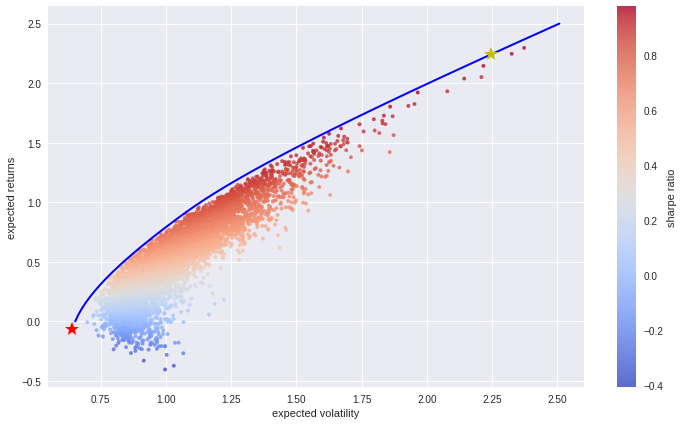

In [55]:
plt.figure(figsize=(12, 7))
plt.scatter(pvols, prets, c=prets/pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(target_vols, target_rets, 'b', lw=2.0)
plt.plot(portfolio_volatility(opts['x']), portfolio_returns(opts['x']), 'y*', markersize=15.0)
plt.plot(portfolio_volatility(optv['x']), portfolio_returns(optv['x']), 'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected returns')
plt.colorbar(label='sharpe ratio')

### Capital market line

In [56]:
import scipy.interpolate as sci

ind = np.argmin(target_vols)
evols = target_vols[ind:]
erets = target_rets[ind:]

tck = sci.splrep(evols, erets)

def f(x):
    """ Efficient frontier function (splines approximation). """
    return sci.splev(x, tck, der=0)
def df(x):
    """ First derivative of efficient frontier function. """
    return sci.splev(x, tck, der=1)
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

opt = sco.fsolve(equations, [0.01, 0.5, 0.15])
opt

array([0.01      , 0.99317929, 2.30079828])

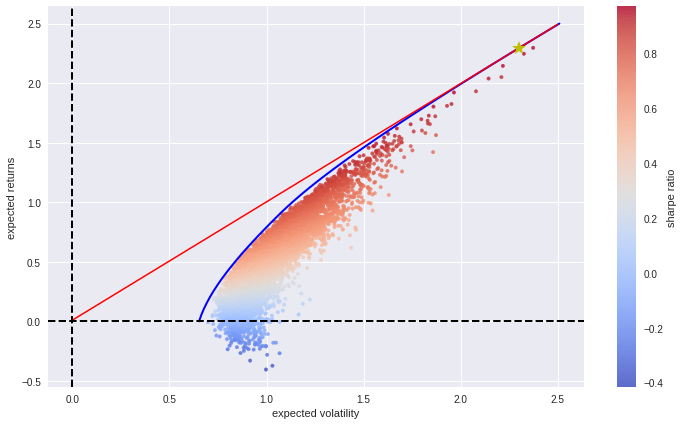

In [57]:
plt.figure(figsize=(12, 7))
plt.scatter(pvols, prets, c=(prets - 0.01) / pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(evols, erets, 'b', lw=2.0)

cx = np.linspace(0.0, 2.5)
plt.plot(cx, opt[0] + opt[1] * cx, 'r', lw=1.5)
plt.plot(opt[2], f(opt[2]), 'y*', markersize=15.0)
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)

plt.xlabel('expected volatility')
plt.ylabel('expected returns')
plt.colorbar(label='sharpe ratio')

In [58]:
cons = (
    { 'type': 'eq', 'fun': lambda x: portfolio_returns(x) - f(opt[2])},
    { 'type': 'eq', 'fun': lambda x: np.sum(x) - 1 }
)
bnds = tuple((0, 1) for _ in range(len(stocks)))


res = sco.minimize(
    portfolio_volatility,
    eweights,
    method='SLSQP',
    bounds=bnds,
    constraints=cons
)

print(stocks)
print('weights', res['x'].round(3))
print('returns', portfolio_returns(res['x']).round(5) * 100, '%')
print('volatility', portfolio_volatility(res['x']))
print('sharpe ratio', portfolio_returns(res['x']) / portfolio_volatility(res['x']))

['BTC-EUR', 'ETH-EUR', 'DOGE-EUR', 'ADA-EUR', 'SHIB-EUR']
weights [0.    0.264 0.    0.    0.736]
returns 229.51100000000002 %
volatility 2.300798278980413
sharpe ratio 0.9975256107348768
